### Background notes

In `exhibit` you can generate numerical values either from a uniform random distribution or from a normal distribution. These values can then be coerced to either floats or integers (as a hack to get discrete values like 0 and 1). It's unlikely you'd want to use generated values as is, so we apply linear scaling before returning the values to the user.

To draw from a uniform distribution all we need is a starting value and the optional dispersion (noise) percentage to shift the final value around. This uniform value is still affected by feature weights, but with dispersion set to 0 you can get consistent values for the same row values. 

For normal distribution, you'd need the mean and the standard deviation. The two statistics, however, will change by the time you finish generating the dataset because for each row, the weights will affect the mean. Thus, you can use them as initial values, but will have to rescale at the end if you want to keep the original values. If the mean / std are commented out in the spec (user intending to scale to range, for example), then we'll use default mean of 1 (having it as zero will negate mean shifting by weights) and standard deviation of 1.

Additionally, if the generated distribution has negative values, we will shift the whole set to be in the positive territory if the scaling is set to `target_sum`; other scaling options can be used with negative ranges / statistics.

The scaling options are:

 - target range
 - target statistic (`sum`, `mean`, `std`)
 
The goal of the scaling options is to match user expectations and to preseve the shape of the data. Unfortunately, you can't have all matching statistics so by choosing to align to a certain metric, you leave others free-floating. This is so that we don't lose information from the weights and preseve the shape of the data.

| scaling | min / max | sum | mean | standard deviation | weights |
| :- | :- | :- | :- | :- | :- |
| target range | preserved | free-floating | free-floating | free-floating | __*__ |
| target statistic (sum) | free-floating | preserved | free-floating | free-floating | preserved |
| target statistic (mean + std) | free-floating | free-floating | preserved | preserved | preserved |

__\*__ _if the ratio between target_min and target_max doesn't match the generated min and max, either the weights will change
or one of the target ranges will need to be adjusted. For example, assume you have 4 values influencing the weights - `0.05, 0.15, 0.3, 0.4`. You want to scale your generated data to between 10 and 150. Without scaling, the generated data can have values like `25, 75, 150, 200`. Now, the ratio `0.3 / 0.15` is the same as `150 / 75`. However, if we scale to between 10 and 150, we get `10, 50, 110, 150`. And here, we're dealing with intervals - `0.1 = 40` so values with weights 0.15 and 0.3 are separated by 60. Although this is not particularly intuitive, it's still preferable over adjusting the `target_max` like so `target_max = (target_min * generated.max()) / generated.min()` because often you have to have fixed min-max ranges and also adjusting the maximum in this way can lead to unexpected results, like pushing the maximum into the negative territory._

When generating the specification from the original data, we populate all potential fields: `min`, `max`, `sum`, etc. Rather than creating separate functions for different statistics, we'll try to make sense of what we're given and issue a warning if an impossible or conflicting situation is given.

For example:

| min | max | sum | mean | standard deviation | outcome |
| :- | :- | :- | :- | :- |:- |
| given | missing | missing | missing | missing | derive the missing end of the range
| given | given | missing | missing | missing | valid
| given | given | given | given | given | warning - use sum as default
| missing | missing | given | given | given | warning - use sum as default
| missing | missing | missing | given | given | scale to both


#### Scaling functions
Scaling floats works as expected. However, as soon as you ask for discrete values, we're at the mercy of rounding which is OK in the large registers, but will produce highly imbalanced datasets when values are low or when standard deviation is small. We try to compensate for it in both scaling to range and scaling to target sum, but if we only have mean / standard deviation to work with, the results will likely be quite imprecise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def scale_to_mean_std(array, target_mean=100, target_std=20, discrete=False):
    
    arr = np.array(array)
    
    result = target_mean + (arr - arr.mean()) * target_std / arr.std()
    
    if discrete:
        result = result.round()
    
    return result

In [3]:
def scale_to_range(array, target_min=None, target_max=None, discrete=False):
    
    X = np.array(array)
    
    # adjust for potential negative signs!
    if not target_min:

        target_min = target_max - (abs(target_max) - abs(target_max * X.min() / X.max()))
    
    if not target_max:

        target_max = target_min + abs(target_min * X.max() / X.min()) - abs(target_min)

    if discrete:

        target_range = int(np.ceil(target_max) - np.floor(target_min))
        bins = np.linspace(X.min(), X.max(), target_range + 2)
        labels = np.arange(np.floor(target_min), np.ceil(target_max) + 1)

        result = pd.cut(X, bins=bins, right=True, include_lowest=True, labels=labels).to_numpy()
        
        return result
    
    result = (X - X.min()) / (X.max() - X.min()) * (target_max - target_min) + target_min

    return result

In [4]:
def scale_to_sum(array, target_sum=200, discrete=False):
    
    series = pd.Series(array)
    
    if any(series < 0):
        series = series + abs(series.min())
    
    scaling_factor = target_sum / series.dropna().sum()
    scaled_series = series * scaling_factor
    
    if discrete:
        
        row_diff = (target_sum - series.dropna().sum()) / len(series.dropna())
        values = pd.Series(
            np.where(
                series + row_diff >= 0,
                series + row_diff,
                np.where(pd.isnull(series), np.NaN, 0)
                )
        )
    
        #how many rows will need to be rounded up to get to target
        boundary = int(target_sum - np.floor(values).sum())

        #because values are limited at the lower end at zero, sometimes it's not possible
        #to adjust them to a lower target_sum; we floor them and return
        if boundary < 0:
            return pd.Series(np.floor(values)).to_numpy()

        #if series has NAs, then the calcualtion will be off
        clean_values = values.dropna() #keep original index

        #np.ceil and floor return Series so index is preserved
        values.update(np.maximum(np.ceil(clean_values.iloc[0:boundary]), 1))
        values.update(np.floor(clean_values.iloc[boundary:]))

        #return a series of ints or cast to float if there are any NAs
        #see https://github.com/pandas-dev/pandas/issues/29618
        #before migrating to the new Pandas null-aware int dtype
        scaled_series = values if values.isna().any() else values.astype(int)
    
    return scaled_series

In [5]:
def transform_datasets(datasets, func, **kwargs):

    new_datasets = {}

    for i, dataset in datasets.items():
        new_datasets[i] = (
            func(dataset[0], **kwargs),
            func(dataset[1], **kwargs)
        )
    
    return new_datasets

In [6]:
def plot_original_quartet(datasets):
    '''
    From Matplotlib gallery: https://matplotlib.org/stable/gallery/specialty_plots/anscombe.html
    '''

    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6),
                            gridspec_kw={'wspace': 0.08, 'hspace': 0.08})
            
    for ax, (label, (x, y)) in zip(axs.flat, datasets.items()):
        ax.text(0.1, 0.9, label, fontsize=20, transform=ax.transAxes, va='top')
        ax.tick_params(direction='in', top=True, right=True)
        ax.plot(x, y, 'o')


    plt.show()

In [7]:
def plot_scaled_quartets(float_dataset, discrete_dataset):

    fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12, 6),
                            gridspec_kw={'wspace': 0.08, 'hspace': 0.08})
    
    colors = ["firebrick", "teal"]
    
    for i, j in enumerate(range(0, 4, 2)):
        
        if i == 0:
            dataset = float_dataset
        else: 
            dataset = discrete_dataset
            
        for ax, (label, (x, y)) in zip(axs[:, j:j+2].flat, dataset.items()):
            ax.text(0.1, 0.9, label, fontsize=20, transform=ax.transAxes, va='top')
            ax.tick_params(direction='in', top=True, right=True)
            ax.plot(x, y, 'o', c=colors[i])
            
    axs[0, 0].set_title("Float", loc="left") 
    axs[0, 2].set_title("Discrete", loc="left") 

    plt.show()

#### Original Anscombe's Quartet datasets

In [8]:
x =  [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

datasets = {
    'I': (x, y1),
    'II': (x, y2),
    'III': (x, y3),
    'IV': (x4, y4)
}

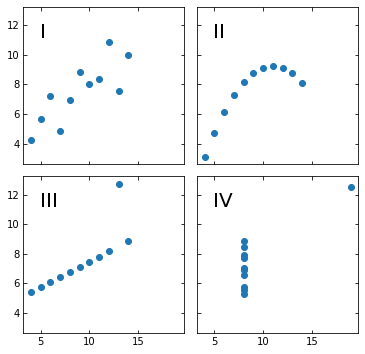

In [9]:
plot_original_quartet(datasets)

#### Scaling to a given mean and standard deviation
No difference between float and discrete option

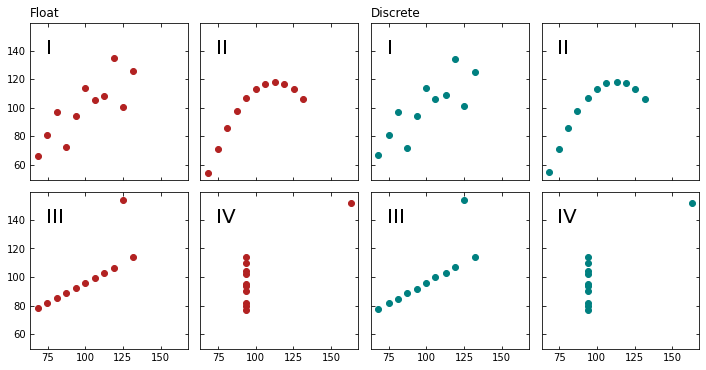

In [10]:
mean_std_datasets_float = transform_datasets(datasets, scale_to_mean_std, discrete=False)
mean_std_datasets_discrete = transform_datasets(datasets, scale_to_mean_std, discrete=True)

plot_scaled_quartets(mean_std_datasets_float, mean_std_datasets_discrete)

#### Scaling to given range
No difference between float and discrete option

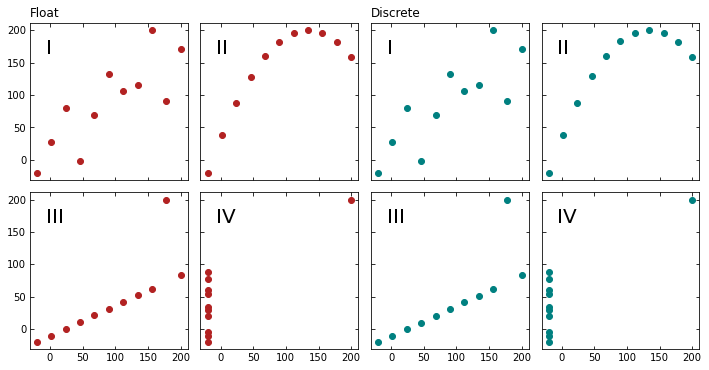

In [11]:
range_datasets_float = transform_datasets(datasets, scale_to_range, discrete=False, target_min=-20, target_max=200)
range_datasets_discrete = transform_datasets(datasets, scale_to_range, discrete=True, target_min=-20, target_max=200)

plot_scaled_quartets(range_datasets_float, range_datasets_discrete)

#### Scaling to given target sum
Discrete will change the shape of the distribution somewhat - particularly if the values are small

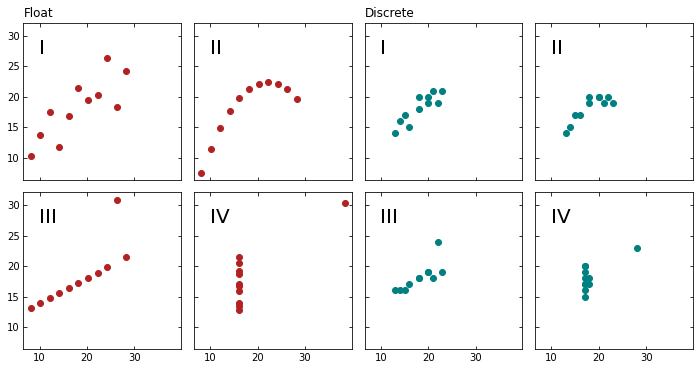

In [12]:
target_sum_datasets_float = transform_datasets(datasets, scale_to_sum, discrete=False)
target_sum_datasets_discrete = transform_datasets(datasets, scale_to_sum, discrete=True)

plot_scaled_quartets(target_sum_datasets_float, target_sum_datasets_discrete)

#### Multivariate distribution
These examples are closer to the real use case where the final distribution is made up from a number of normal distributions with a varying mean.

Code adapted from this SO [answer](https://stackoverflow.com/questions/47759577/creating-a-mixture-of-probability-distributions-for-sampling).

In [13]:
def plot_distribution(float_dataset, discrete_dataset,):

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6),
                            gridspec_kw={'wspace': 0.08, 'hspace': 0.08})
    
    colors = ["firebrick", "teal"]
    
    for i in range(2):
        
        if i == 0:
            dataset = float_dataset
        else: 
            dataset = discrete_dataset
        
        axs[i].hist(dataset, bins=100, density=False, color=colors[i], alpha=0.5)
        
            
    axs[0].set_title("Float", loc="left") 
    axs[1].set_title("Discrete", loc="left") 

    plt.show()

In [14]:
distributions = [
    {"type": np.random.normal, "kwargs": {"loc": 20, "scale": 2}},
    {"type": np.random.normal, "kwargs": {"loc": 10, "scale": 3}},
    {"type": np.random.normal, "kwargs": {"loc": 5, "scale": 1}},
]
coefficients = np.array([0.5, 0.2, 0.3])
coefficients /= coefficients.sum()
sample_size = 100000

num_distr = len(distributions)
data = np.zeros((sample_size, num_distr))
for idx, distr in enumerate(distributions):
    data[:, idx] = distr["type"](size=(sample_size,), **distr["kwargs"])
random_idx = np.random.choice(np.arange(num_distr), size=(sample_size,), p=coefficients)
sample = data[np.arange(sample_size), random_idx]

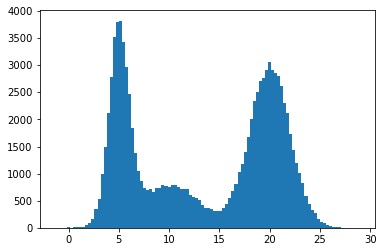

In [15]:
plt.hist(sample, bins=100)
plt.show()

#### Scale to positive mean and standard distribution

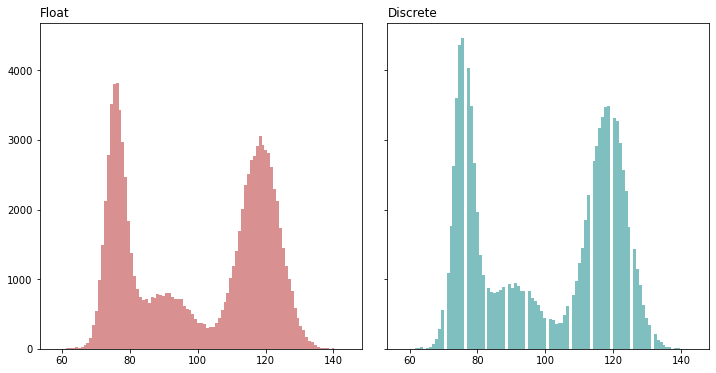

In [16]:
mean_std_float = scale_to_mean_std(sample, discrete=False)
mean_std_discrete = scale_to_mean_std(sample, discrete=True)

plot_distribution(mean_std_float, mean_std_discrete)

#### Scale to negative mean and standard distribution

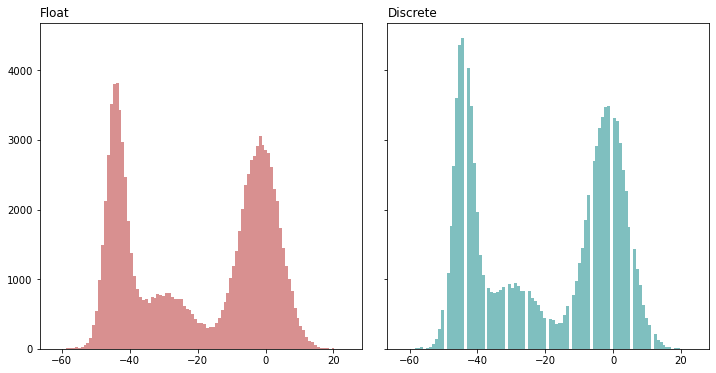

In [17]:
mean_std_float = scale_to_mean_std(sample, target_mean=-20, discrete=False)
mean_std_discrete = scale_to_mean_std(sample, target_mean=-20, discrete=True)

plot_distribution(mean_std_float, mean_std_discrete)

#### Scale to a given range
Both ranges are given

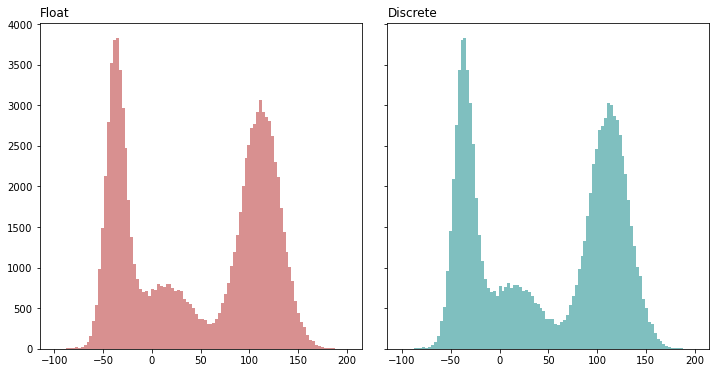

In [18]:
range_float = scale_to_range(sample, discrete=False, target_min=-100, target_max=200)
range_discrete = scale_to_range(sample, discrete=True, target_min=-100, target_max=200)

plot_distribution(range_float, range_discrete)

##### Special case if only one of the ranges is given (negative min)

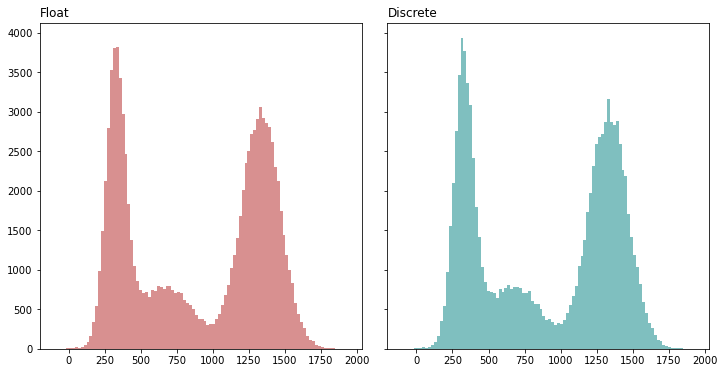

In [19]:
range_float = scale_to_range(sample, discrete=False, target_min=-100)
range_discrete = scale_to_range(sample, discrete=True, target_min=-100)

plot_distribution(range_float, range_discrete)

##### Special case if only one of the ranges is given (small max)

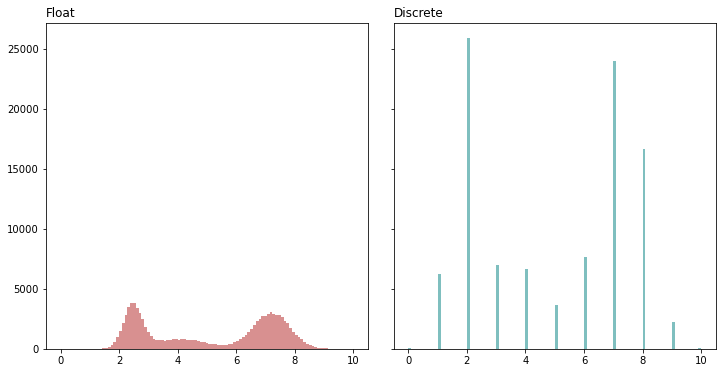

In [20]:
range_float = scale_to_range(sample, discrete=False, target_max=10)
range_discrete = scale_to_range(sample, discrete=True, target_max=10)

plot_distribution(range_float, range_discrete)

##### Special case for 0 and 1

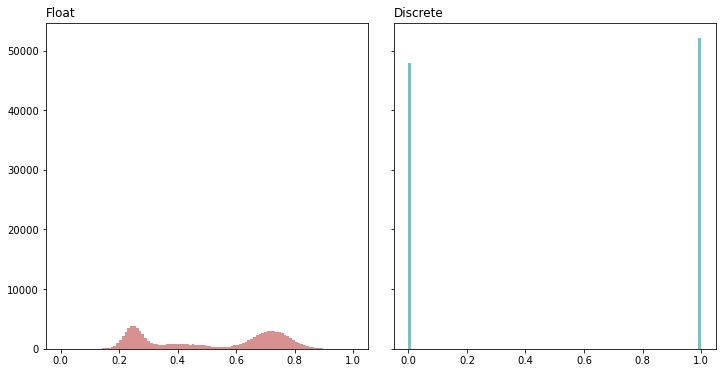

In [21]:
range_float = scale_to_range(sample, discrete=False, target_min=0, target_max=1)
range_discrete = scale_to_range(sample, discrete=True, target_min=0, target_max=1)

plot_distribution(range_float, range_discrete)

#### Scale to a target sum
Given a large enough sum (corresponding to the 10_000 samples!), it's OK. But at smaller values zeroes will dominate.

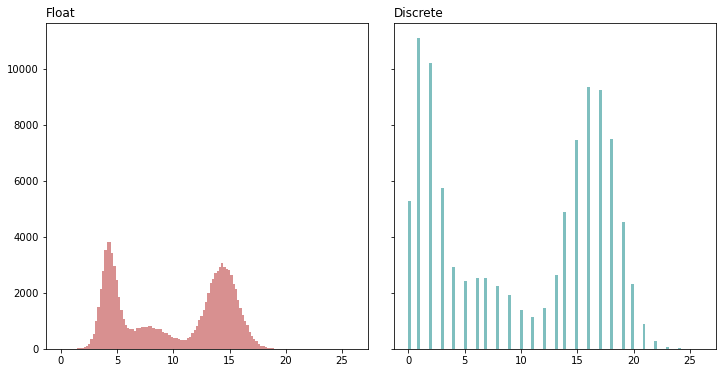

In [22]:
sum_float = scale_to_sum(sample, discrete=False, target_sum=1_000_000)
sum_discrete = scale_to_sum(sample, discrete=True, target_sum=1_000_000)

plot_distribution(sum_float, sum_discrete)